Making plots for the Aug 14 (2019) telecon

In [1]:
from __future__ import division, print_function
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
import sys, os, glob, time, warnings, gc
# import healpy as hp

from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import LogNorm

sys.path.append(os.path.expanduser('~/git/desi-lrg-selection'))
import plotting_scripts as lrg_plot
import importlib
importlib.reload(lrg_plot)

<module 'plotting_scripts' from '/Users/rongpu/git/desi-lrg-selection/plotting_scripts.py'>

In [2]:
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
downsample_factor = 32
field = 'south'

In [4]:
cat_columns = ['TYPE', 'RA', 'DEC', 'EBV', 
          'FLUX_G_EC', 'FLUX_R_EC', 'FLUX_Z_EC', 'FLUX_W1_EC', 'FLUX_W2_EC', 'FLUX_IVAR_G', 'FLUX_IVAR_R', 'FLUX_IVAR_Z', 'FLUX_IVAR_W1', 'FLUX_IVAR_W2', 
          'NOBS_G', 'NOBS_R', 'NOBS_Z', 'NOBS_W1', 'NOBS_W2', 
          'FIBERFLUX_G_EC', 'FIBERFLUX_R_EC', 'FIBERFLUX_Z_EC', 
          'MASKBITS',
          'z_phot_mean', 'z_phot_median', 'z_phot_std', 'z_phot_l68', 'z_phot_u68', 'z_phot_l95', 'z_phot_u95',
          'z_spec', 'survey', 'training']

# cat = fitsio.read('/global/cscratch1/sd/rongpu/dr8_lrg_photoz/lrg_extended_20190724_ds_south.fits', columns=cat_columns)
cat = fitsio.read('/Users/rongpu/Documents/Data/desi_photoz/catalogs/dr8.0/lrg_extended_20190724_ds_south.fits', columns=cat_columns)
cat = Table(cat)
print(len(cat))
if field=='south':
    mask = cat['DEC']<32.375
elif field=='north':
    mask = cat['DEC']>32.375
else:
    raise ValueError('invalid field')
mask &= (cat['NOBS_G']>=2) & (cat['NOBS_R']>=2) & (cat['NOBS_Z']>=2)
mask &= cat['DEC']>-30
cat = cat[mask]
print(len(cat))

randoms_columns = ['RA', 'DEC', 'NOBS_G', 'NOBS_R', 'NOBS_Z', 'MASKBITS']
# randoms = fitsio.read('/global/project/projectdirs/cosmo/data/legacysurvey/dr8/randoms/randoms-inside-dr8-0.31.0-1.fits', 
#                       columns=randoms_columns)
randoms_full_size = 101662375
randoms_load_size = int(1e7)
randoms_density = 5000/randoms_full_size*randoms_load_size
randoms = fitsio.read('/Users/rongpu/Documents/Data/desi_photoz/catalogs/dr8.0/randoms-inside-dr8-0.31.0-1.fits', 
                      columns=randoms_columns, rows=np.arange(randoms_load_size))
print(len(randoms))
if field=='south':
    mask = randoms['DEC']<32.375
elif field=='north':
    mask = randoms['DEC']>32.375
else:
    raise ValueError('invalid field')
mask &= (randoms['NOBS_G']>=2) & (randoms['NOBS_R']>=2) & (randoms['NOBS_Z']>=2)
mask &= randoms['DEC']>-30
randoms = randoms[mask]
print(len(randoms))

5754830
4635563
10000000
5276291


__Clean up the data__

In [5]:
# Apply maskbit
mask_bad = (cat['MASKBITS']&(2**1)>0) | (cat['MASKBITS']&(2**8)>0) | (cat['MASKBITS']&(2**9)>0) | (cat['MASKBITS']&(2**11)>0) | (cat['MASKBITS']&(2**12)>0) | (cat['MASKBITS']&(2**13)>0)
print('{:} ({:.1f}%) objects removed due to maskbits'.format(np.sum(mask_bad), np.sum(mask_bad)/len(mask_bad)*100))
cat = cat[~mask_bad]
print(len(cat))

mask_bad = (randoms['MASKBITS']&(2**1)>0) | (randoms['MASKBITS']&(2**8)>0) | (randoms['MASKBITS']&(2**9)>0) | (randoms['MASKBITS']&(2**11)>0) | (randoms['MASKBITS']&(2**12)>0) | (randoms['MASKBITS']&(2**13)>0)
print('{:} ({:.1f}%) randoms removed due to maskbits'.format(np.sum(mask_bad), np.sum(mask_bad)/len(mask_bad)*100))
randoms = randoms[~mask_bad]
print(len(randoms))

324357 (7.0%) objects removed due to maskbits
4311206
311228 (5.9%) randoms removed due to maskbits
4965063


__Basic quality cuts__

In [6]:
mask = (cat['FLUX_R_EC']>0) & (cat['FLUX_IVAR_R']>0)
mask &= (cat['FLUX_Z_EC']>0) & (cat['FLUX_IVAR_Z']>0)
mask &= (cat['FLUX_W1_EC']>0) & (cat['FLUX_IVAR_W1']>0)
print(np.sum(~mask)/len(mask), np.sum(mask))
cat = cat[mask]

6.262748752901161e-05 4310936


In [7]:
# Pre-computed area (from dr7/LRG_density_variation-Eisenstein_IR.ipynb)
area_clean = len(randoms)/randoms_density
print('Arae = {:.2f} sq. deg.'.format(area_clean))

Arae = 10095.20 sq. deg.


In [8]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    gmag = 22.5 - 2.5*np.log10(cat['FLUX_G_EC'])
    rmag = 22.5 - 2.5*np.log10(cat['FLUX_R_EC'])
    zmag = 22.5 - 2.5*np.log10(cat['FLUX_Z_EC'])
    w1mag = 22.5 - 2.5*np.log10(cat['FLUX_W1_EC'])
    w2mag = 22.5 - 2.5*np.log10(cat['FLUX_W2_EC'])
    zfibermag = 22.5 - 2.5*np.log10(cat['FIBERFLUX_Z_EC'])
    rfibermag = 22.5 - 2.5*np.log10(cat['FIBERFLUX_R_EC'])

    gmag[~np.isfinite(gmag)] = 100.
    rmag[~np.isfinite(rmag)] = 100.
    zmag[~np.isfinite(zmag)] = 100.
    w1mag[~np.isfinite(w1mag)] = 100.
    w2mag[~np.isfinite(w2mag)] = 100.
    rfibermag[~np.isfinite(rfibermag)] = 100.
    zfibermag[~np.isfinite(zfibermag)] = 100.
    
    gflux_ivar = cat['FLUX_IVAR_R']
    
    cat['z_phot'] = cat['z_phot_median']

In [9]:
cat.add_columns([gmag, rmag, zmag, w1mag, w2mag, zfibermag, rfibermag], names=['gmag', 'rmag', 'zmag', 'w1mag', 'w2mag', 'zfibermag', 'rfibermag'])

In [10]:
# Perturb the photo-z's by the estimated errors
cat['z_phot_1_sigma'] = (cat['z_phot_u68']-cat['z_phot_l68'])/2
np.random.seed(123)
z_phot_perturb = cat['z_phot_median'] + np.random.randn(len(cat)) * cat['z_phot_1_sigma']

In [11]:
def print_summary(mask):
    print('Conservative 1-pass/2-pass boundary:')
    n1v = np.sum(zmag[mask]<20.0)
    n2v = np.sum(zmag[mask]>20.0)
    print('    target density: {:.1f} ({:.1f}+{:.1f}) per sq deg'
          .format(np.sum(mask)/area_clean*downsample_factor, 
                  n1v/area_clean*downsample_factor, n2v/area_clean*downsample_factor))
    print('    exposure density: {:.1f} per sq deg'.format((n1v+2*n2v)/area_clean*downsample_factor))
    
def print_summary_new(mask):
    print('Optimistic 1-pass/2-pass boundary:')
    n1v = np.sum(zfibermag[mask]<21.5)
    n2v = np.sum(zfibermag[mask]>21.5)
    print('    target density: {:.1f} ({:.1f}+{:.1f}) per sq deg'
          .format(np.sum(mask)/area_clean*downsample_factor, 
                  n1v/area_clean*downsample_factor, n2v/area_clean*downsample_factor))
    print('    exposure density: {:.1f} per sq deg'.format((n1v+2*n2v)/area_clean*downsample_factor))

-------

In [43]:
x1min, x1max, y1min, y1max = 0., 1.5, 0.8, 1.55
x2min, x2max, y2min, y2max = x1max, 3.5, y1max, 1.55

slope1 = (y1max-y1min)/(x1max-x1min)
intercept1 = y1min - slope1*x1min
print(slope1, intercept1)
x1 = np.linspace(-1, x1max)
y1 = slope1 * x1 + intercept1

slope2 = (y2max-y2min)/(x2max-x2min)
intercept2 = y2min - slope2*x2min
print(slope2, intercept2)
x2 = np.linspace(x2min, 4)
y2 = slope2 * x2 + intercept2

0.5 0.8
0.0 1.55


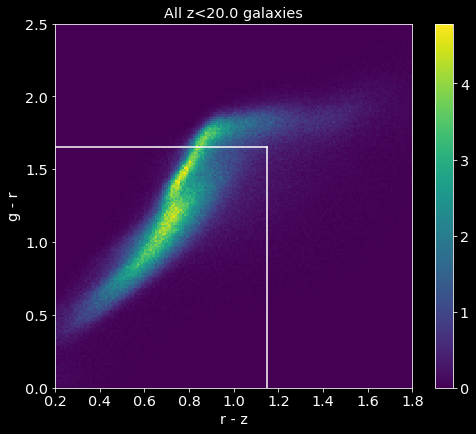

In [15]:
# Plot g-r vs r-z selection
with plt.style.context(('dark_background')):

    x1_old = np.linspace(0, 1.15)
    y1_old = 1.65 * np.ones(len(x1_old))
    y2_old = np.linspace(0, 1.65)
    x2_old = 1.15 * np.ones(len(y2_old))
    
    lrg_mask = zmag - w1mag > 0.8*(rmag-zmag) - 0.6  # non-stellar cut
    lrg_mask &= zmag < 20.0                          # faint limit
    fig, ax = plt.subplots(figsize=(8, 6.7))
    bins = [np.linspace(0.2, 1.8, 200), np.linspace(0, 2.5, 200)]
    im = ax.hist2d((rmag-zmag)[lrg_mask], (gmag-rmag)[lrg_mask], 
        bins=bins, density=True)
    ax.plot(x1_old, y1_old, color='w')
    ax.plot(x2_old, y2_old, color='w')
    fig.colorbar(im[3], ax=ax)
    ax.set_xlabel('r - z')
    ax.set_ylabel('g - r')
    ax.set_title('All z<20.0 galaxies')
    plt.show()

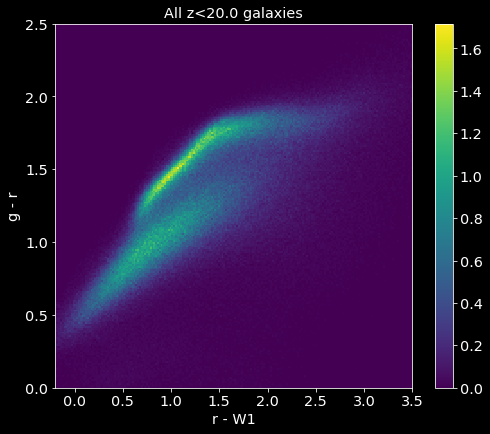

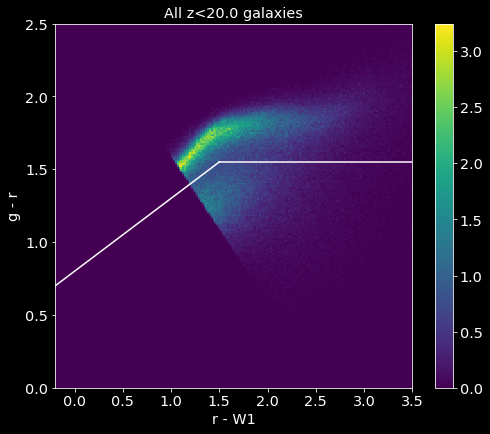

In [47]:
with plt.style.context(('dark_background')):    

    lrg_mask = zmag - w1mag > 0.8*(rmag-zmag) - 0.6  # non-stellar cut
    lrg_mask &= zmag < 20.0                          # faint limit
    fig, ax = plt.subplots(figsize=(8, 6.7))
    bins = [np.linspace(-0.2, 3.5, 200), np.linspace(0, 2.5, 200)]
    im = ax.hist2d((rmag-w1mag)[lrg_mask], (gmag-rmag)[lrg_mask], 
        bins=bins, density=True)
    # ax.plot(x1, y1, color='w')
    # ax.plot(x2, y2, color='w')
    fig.colorbar(im[3], ax=ax)
    ax.set_xlabel('r - W1')
    ax.set_ylabel('g - r')
    ax.set_title('All z<20.0 galaxies')
    plt.show()
    
    lrg_mask = zmag - w1mag > 0.8*(rmag-zmag) - 0.6  # non-stellar cut
    lrg_mask &= zmag < 20.0                          # faint limit
    lrg_mask &= gmag - w1mag > 2.6
    fig, ax = plt.subplots(figsize=(8, 6.7))
    bins = [np.linspace(-0.2, 3.5, 200), np.linspace(0, 2.5, 200)]
    im = ax.hist2d((rmag-w1mag)[lrg_mask], (gmag-rmag)[lrg_mask], 
        bins=bins, density=True)
    ax.plot(x1, y1, color='w')
    ax.plot(x2, y2, color='w')
    fig.colorbar(im[3], ax=ax)
    ax.set_xlabel('r - W1')
    ax.set_ylabel('g - r')
    ax.set_title('All z<20.0 galaxies')
    plt.show()

----------

In [37]:
def density_optical(lrg_mask, lognorm=True):
    cmin, cmax, normed, kwargs = None, None, True, {}
    if lognorm:
        kwargs['norm'] = LogNorm()
    with plt.style.context(('dark_background')):
        # optical sliding cut
        fig, ax = plt.subplots(figsize=(8, 6.7))
        bins = [np.linspace(18., 21., 200), np.linspace(0.8, 2.2, 200)]
        im = ax.hist2d((cat['zmag'])[lrg_mask], (cat['rmag']-cat['zmag'])[lrg_mask], 
            bins=bins, cmin=cmin, cmax=cmax, density=normed, **kwargs)
        ax.set_xlabel('z')
        ax.set_ylabel('r - z')
        fig.colorbar(im[3], ax=ax)
        plt.show()
        
def density_ir(lrg_mask, lognorm=True):
    cmin, cmax, normed, kwargs = None, None, True, {}
    if lognorm:
        kwargs['norm'] = LogNorm()
    with plt.style.context(('dark_background')):
        # IR sliding cut
        fig, ax = plt.subplots(figsize=(8, 6.7))
        bins = [np.linspace(17.2, 19.4, 200), np.linspace(0.9, 4, 200)]
        im = ax.hist2d((cat['w1mag'])[lrg_mask], (cat['rmag']-cat['w1mag'])[lrg_mask], 
            bins=bins, cmin=cmin, cmax=cmax, density=normed, **kwargs)
        fig.colorbar(im[3], ax=ax)
        ax.set_xlabel('W1')
        ax.set_ylabel('r - W1')
        plt.show()

target density: 538.5 (402.3+136.2) per sq deg
exposure density: 674.6 per sq deg


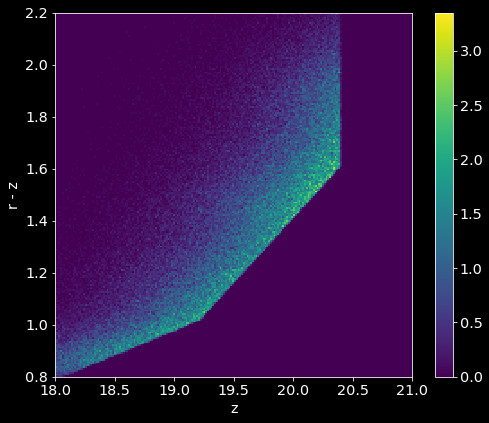

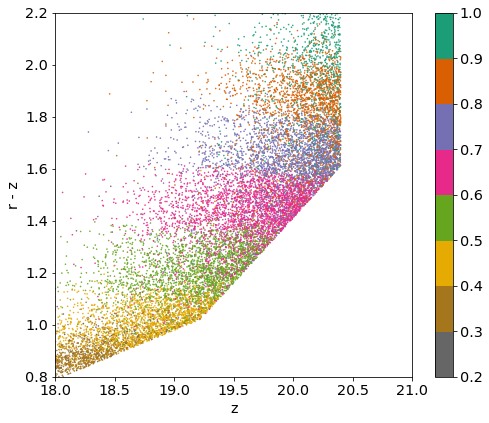

In [32]:
# nominal optical selection
lrg_mask = zmag - w1mag > 0.8*(rmag-zmag) - 0.6  # non-stellar cut
lrg_mask &= (zmag < 20.4)                        # faint limit

mask_red = gmag - w1mag > 2.6                    # low-z cut
mask_red &= (gmag-rmag) > 1.4                    # red selection
mask_red |= (rmag-w1mag) > 1.8                   # ignore low-z cut for faint objects
lrg_mask &= mask_red

lrg_mask &= rmag - zmag > (zmag - 17.18) / 2     # sliding optical cut
lrg_mask &= rmag - zmag > (zmag - 13.85) * 0.19  # low-z sliding optical cut

print_summary(lrg_mask)

density_optical(lrg_mask, lognorm=False)

vmin, vmax = 0.2 ,1.0
cmap='Dark2_r'

idx = np.random.choice(np.where(lrg_mask)[0], size=15000, replace=False)

fig, ax = plt.subplots(figsize=(8, 6.7))
im = ax.scatter((zmag)[idx], (rmag-zmag)[idx], 
         c=cat['z_phot'][idx], s=0.3, cmap=cmap, vmin=vmin, vmax=vmax)
ax.set_xlabel('z')
ax.set_ylabel('r - z')
ax.axis([18., 21., 0.8, 2.2])
fig.colorbar(im, ax=ax)
plt.show()

target density: 556.9 (408.1+148.8) per sq deg
exposure density: 705.7 per sq deg


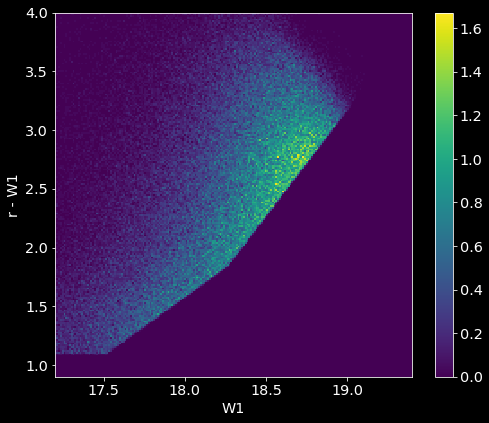

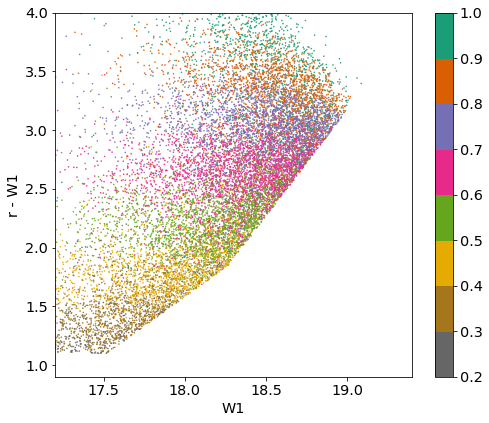

In [38]:
# nominal IR selection
lrg_mask = zmag - w1mag > 0.8*(rmag-zmag) - 0.6  # non-stellar cut        
lrg_mask &= (zmag < 20.4)                    # faint limit
lrg_mask &= rmag - zmag > 0.75                    # broad color box
lrg_mask &= (rmag - w1mag > 1.1) # Low-z cut
lrg_mask &= rmag - w1mag > (w1mag - 17.24) * 1.8  # sliding IR cut
lrg_mask &= rmag - w1mag > (w1mag - 16.42) * 1.  # low-z sliding IR cut

print_summary(lrg_mask)

density_ir(lrg_mask, lognorm=False)

idx = np.random.choice(np.where(lrg_mask)[0], size=15000, replace=False)

# IR sliding cut
fig, ax = plt.subplots(figsize=(8, 6.7))
im = ax.scatter((w1mag)[idx], (rmag-w1mag)[idx], 
         c=cat['z_phot'][idx], s=0.3, cmap=cmap, vmin=vmin, vmax=vmax)
ax.set_xlabel('W1')
ax.set_ylabel('r - W1')
ax.axis([17.2, 19.4, 0.9, 4])
fig.colorbar(im, ax=ax)

plt.show()

------

In [21]:
lrg_mask_opt = zmag - w1mag > 0.8*(rmag-zmag) - 0.6  # non-stellar cut
lrg_mask_opt &= (zmag < 20.4)                        # faint limit

mask_red = gmag - w1mag > 2.6                    # low-z cut
mask_red &= (gmag-rmag) > 1.4                    # red selection
mask_red |= (rmag-w1mag) > 1.8                   # ignore low-z cut for faint objects
lrg_mask_opt &= mask_red

lrg_mask_opt &= rmag - zmag > (zmag - 17.18) / 2     # sliding optical cut
lrg_mask_opt &= rmag - zmag > (zmag - 13.85) * 0.19  # low-z sliding optical cut

print_summary(lrg_mask_opt)

target density: 538.5 (402.3+136.2) per sq deg
exposure density: 674.6 per sq deg


In [22]:
lrg_mask_ir = zmag - w1mag > 0.8*(rmag-zmag) - 0.6  # non-stellar cut        
lrg_mask_ir &= (zmag < 20.4)                    # faint limit
lrg_mask_ir &= rmag - zmag > 0.75                    # broad color box
lrg_mask_ir &= (rmag - w1mag > 1.1) # Low-z cut
lrg_mask_ir &= rmag - w1mag > (w1mag - 17.24) * 1.8  # sliding IR cut
lrg_mask_ir &= rmag - w1mag > (w1mag - 16.42) * 1.  # low-z sliding IR cut

print_summary(lrg_mask_ir)

target density: 556.9 (408.1+148.8) per sq deg
exposure density: 705.7 per sq deg


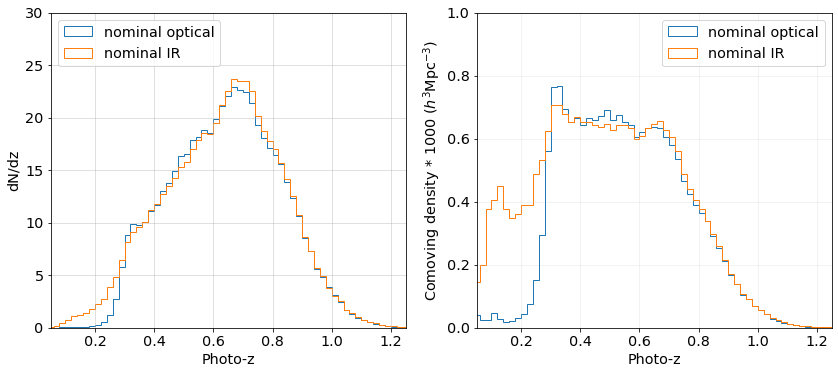

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5.8))
bins = np.arange(0.04, 1.44, 0.02)
axes[0].hist(z_phot_perturb[lrg_mask_opt], bins=bins, label='nominal optical', 
             weights=np.ones(int(np.sum(lrg_mask_opt)))/area_clean*downsample_factor, histtype='step')
axes[0].hist(z_phot_perturb[lrg_mask_ir], bins=bins, label='nominal IR', 
             weights=np.ones(int(np.sum(lrg_mask_ir)))/area_clean*downsample_factor, histtype='step')
axes[0].set_xlabel('Photo-z')
axes[0].set_ylabel('dN/dz')
axes[0].set_xlim(0.05, 1.25)
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
# axes[0].set_ylim(0, 21.5)
axes[0].grid(alpha=0.5)
axes[0].set_ylim(top=30)
axes[0].legend(loc='upper left')
axes[1] = lrg_plot.plot_comoving_density(z_phot_perturb[lrg_mask_opt], area=area_clean/downsample_factor, zmin=0.04, zmax=1.44, dz=0.02, axis=[0.05, 1.25, 0, 1.], show=False, label='nominal optical')
axes[1] = lrg_plot.plot_comoving_density(z_phot_perturb[lrg_mask_ir], area=area_clean/downsample_factor, zmin=0.04, zmax=1.44, dz=0.02, axis=[0.05, 1.25, 0, 1.], show=False, label='nominal IR')

-------

In [27]:
lrg_mask = zmag - w1mag > 0.8*(rmag-zmag) - 0.6  # non-stellar cut
lrg_mask &= (zmag < 20.4)                        # faint limit
mask_red = gmag - w1mag > 2.6                    # low-z cut
mask_red &= (gmag-rmag) > 1.4                    # red selection
mask_red |= (rmag-w1mag) > 1.8                   # ignore low-z cut for faint objects
lrg_mask &= mask_red
lrg_mask &= rmag - zmag > (zmag - 17.18) / 2     # sliding optical cut
lrg_mask &= rmag - zmag > (zmag - 13.85) * 0.19  # low-z sliding optical cut
lrg_mask_opt = lrg_mask.copy()

lrg_mask = zmag - w1mag > 0.8*(rmag-zmag) - 0.6  # non-stellar cut        
lrg_mask &= (zmag < 20.4)                    # faint limit
lrg_mask &= rmag - zmag > 0.75                    # broad color box
lrg_mask &= (rmag - w1mag > 1.1) # Low-z cut
lrg_mask &= rmag - w1mag > (w1mag - 17.24) * 1.8  # sliding IR cut
lrg_mask &= rmag - w1mag > (w1mag - 16.42) * 1.  # low-z sliding IR cut
lrg_mask_ir = lrg_mask.copy()

lrg_mask_combined = lrg_mask_opt | lrg_mask_ir
print_summary(lrg_mask_combined)

target density: 679.8 (497.6+182.1) per sq deg
exposure density: 861.9 per sq deg


In [12]:
# lrg_plot.density_plot_3x2_new(cat[lrg_mask_combined], lognorm=False)

In [29]:
lrg_mask = zmag - w1mag > 0.8*(rmag-zmag) - 0.8  # non-stellar cut
lrg_mask &= ((zmag < 21.) | (zfibermag < 22.))   # faint limit
mask_red = gmag - w1mag > 2.5                    # low-z cut
mask_red &= (gmag-rmag) > 1.3                    # red selection
mask_red |= (rmag-w1mag) > 1.7                   # ignore low-z cut for faint objects
lrg_mask &= mask_red
# straight cut for low-z:
lrg_mask_lowz = zmag < 20.4
lrg_mask_lowz &= rmag - zmag > (zmag - 17.18 - 0.2) / 2
# curved sliding cut for high-z:
lrg_mask_highz = zmag > 20.4
lrg_mask_highz &= (((zmag - 23.52 - 0.2) / 1.3)**2 + (rmag - zmag + 2.2)**2 > 4.5**2)
lrg_mask &= (lrg_mask_lowz | lrg_mask_highz)

lrg_mask_opt = lrg_mask.copy()

lrg_mask = zmag - w1mag > 0.8*(rmag-zmag) - 0.8  # non-stellar cut        
lrg_mask &= ((zmag < 21.) | (zfibermag < 22.)) # faint limit
lrg_mask &= rmag - zmag > 0.65                    # broad color box
lrg_mask &= (rmag - w1mag > 1.0) # Low-z cut
# curved sliding cut:
lrg_mask &= (w1mag - 21.52 - 0.2)**2 + ((rmag - w1mag + 0.5) / 1.5)**2 >3.5**2
# lrg_mask &= rmag - w1mag > (w1mag - 17.24 - 0.2) * 1.8  # sliding IR cut

lrg_mask_ir = lrg_mask.copy()

lrg_mask_combined = lrg_mask_opt | lrg_mask_ir
print_summary(lrg_mask_combined)

target density: 1876.5 (856.4+1020.1) per sq deg
exposure density: 2896.6 per sq deg


In [13]:
# lrg_plot.density_plot_3x2_new(cat[lrg_mask_combined], lognorm=False)

--------

zfiber < 22.0

In [26]:
zfiber_limit = 22.

lrg_mask = zmag - w1mag > 0.8*(rmag-zmag) - 0.8  # non-stellar cut
lrg_mask &= ((zfibermag < zfiber_limit))   # faint limit
mask_red = gmag - w1mag > 2.5                    # low-z cut
mask_red &= (gmag-rmag) > 1.3                    # red selection
mask_red |= (rmag-w1mag) > 1.7                   # ignore low-z cut for faint objects
lrg_mask &= mask_red
# straight cut for low-z:
lrg_mask_lowz = zmag < 20.4
lrg_mask_lowz &= rmag - zmag > (zmag - 17.18 - 0.2) / 2
# curved sliding cut for high-z:
lrg_mask_highz = zmag > 20.4
lrg_mask_highz &= (((zmag - 23.52 - 0.2) / 1.3)**2 + (rmag - zmag + 2.2)**2 > 4.5**2)
lrg_mask &= (lrg_mask_lowz | lrg_mask_highz)

lrg_mask_opt = lrg_mask.copy()

lrg_mask = zmag - w1mag > 0.8*(rmag-zmag) - 0.8  # non-stellar cut        
lrg_mask &= ((zfibermag < zfiber_limit))   # faint limit
lrg_mask &= rmag - zmag > 0.65                    # broad color box
lrg_mask &= (rmag - w1mag > 1.0) # Low-z cut
# curved sliding cut:
lrg_mask &= (w1mag - 21.52 - 0.2)**2 + ((rmag - w1mag + 0.5) / 1.5)**2 >3.5**2
# lrg_mask &= rmag - w1mag > (w1mag - 17.24 - 0.2) * 1.8  # sliding IR cut

lrg_mask_ir = lrg_mask.copy()

lrg_mask_combined = lrg_mask_opt | lrg_mask_ir
print_summary(lrg_mask_combined)
print_summary_new(lrg_mask_combined)

Conservative 1-pass/2-pass boundary:
    target density: 1820.2 (853.8+966.4) per sq deg
    exposure density: 2786.6 per sq deg
Optimistic 1-pass/2-pass boundary:
    target density: 1820.2 (1292.0+528.2) per sq deg
    exposure density: 2348.3 per sq deg


zfiber < 21.5

In [27]:
zfiber_limit = 21.5

lrg_mask = zmag - w1mag > 0.8*(rmag-zmag) - 0.8  # non-stellar cut
lrg_mask &= ((zfibermag < zfiber_limit))   # faint limit
mask_red = gmag - w1mag > 2.5                    # low-z cut
mask_red &= (gmag-rmag) > 1.3                    # red selection
mask_red |= (rmag-w1mag) > 1.7                   # ignore low-z cut for faint objects
lrg_mask &= mask_red
# straight cut for low-z:
lrg_mask_lowz = zmag < 20.4
lrg_mask_lowz &= rmag - zmag > (zmag - 17.18 - 0.2) / 2
# curved sliding cut for high-z:
lrg_mask_highz = zmag > 20.4
lrg_mask_highz &= (((zmag - 23.52 - 0.2) / 1.3)**2 + (rmag - zmag + 2.2)**2 > 4.5**2)
lrg_mask &= (lrg_mask_lowz | lrg_mask_highz)

lrg_mask_opt = lrg_mask.copy()

lrg_mask = zmag - w1mag > 0.8*(rmag-zmag) - 0.8  # non-stellar cut        
lrg_mask &= ((zfibermag < zfiber_limit))   # faint limit
lrg_mask &= rmag - zmag > 0.65                    # broad color box
lrg_mask &= (rmag - w1mag > 1.0) # Low-z cut
# curved sliding cut:
lrg_mask &= (w1mag - 21.52 - 0.2)**2 + ((rmag - w1mag + 0.5) / 1.5)**2 >3.5**2
# lrg_mask &= rmag - w1mag > (w1mag - 17.24 - 0.2) * 1.8  # sliding IR cut

lrg_mask_ir = lrg_mask.copy()

lrg_mask_combined = lrg_mask_opt | lrg_mask_ir
print_summary(lrg_mask_combined)
print_summary_new(lrg_mask_combined)

Conservative 1-pass/2-pass boundary:
    target density: 1292.0 (841.4+450.6) per sq deg
    exposure density: 1742.6 per sq deg
Optimistic 1-pass/2-pass boundary:
    target density: 1292.0 (1292.0+0.0) per sq deg
    exposure density: 1292.0 per sq deg


Nominal optical with zfiber<21.5 limit

In [29]:
lrg_mask = zmag - w1mag > 0.8*(rmag-zmag) - 0.6  # non-stellar cut
lrg_mask &= (zfibermag < 21.5)                        # faint limit
mask_red = gmag - w1mag > 2.6                    # low-z cut
mask_red &= (gmag-rmag) > 1.4                    # red selection
mask_red |= (rmag-w1mag) > 1.8                   # ignore low-z cut for faint objects
lrg_mask &= mask_red
lrg_mask &= rmag - zmag > (zmag - 17.18) / 2     # sliding optical cut
lrg_mask &= rmag - zmag > (zmag - 13.85) * 0.19  # low-z sliding optical cut
print_summary(lrg_mask)
print_summary_new(lrg_mask)

Conservative 1-pass/2-pass boundary:
    target density: 637.5 (393.5+244.0) per sq deg
    exposure density: 881.5 per sq deg
Optimistic 1-pass/2-pass boundary:
    target density: 637.5 (637.5+0.0) per sq deg
    exposure density: 637.5 per sq deg


Nominal optical with zfiber<21.5 OR z<20.0 limit

In [30]:
lrg_mask_1pass = zmag - w1mag > 0.8*(rmag-zmag) - 0.6  # non-stellar cut
lrg_mask_1pass &= ((zmag < 20.0) | (zfibermag < 21.5))   # faint limit

mask_red = gmag - w1mag > 2.6                    # low-z cut
mask_red &= (gmag-rmag) > 1.4                    # red selection
mask_red |= (rmag-w1mag) > 1.8                   # ignore low-z cut for faint objects
lrg_mask_1pass &= mask_red

lrg_mask_1pass &= rmag - zmag > (zmag - 17.18) / 2     # sliding optical cut
lrg_mask_1pass &= rmag - zmag > (zmag - 13.85) * 0.19  # low-z sliding optical cut

print_summary(lrg_mask_1pass)
print_summary_new(lrg_mask_1pass)

Conservative 1-pass/2-pass boundary:
    target density: 646.3 (402.3+244.0) per sq deg
    exposure density: 890.3 per sq deg
Optimistic 1-pass/2-pass boundary:
    target density: 646.3 (637.5+8.8) per sq deg
    exposure density: 655.2 per sq deg


Nominal optical with zfiber<21.5 OR z<20.4 limit

In [31]:
lrg_mask_1pass = zmag - w1mag > 0.8*(rmag-zmag) - 0.6  # non-stellar cut
lrg_mask_1pass &= ((zmag < 20.4) | (zfibermag < 21.5))   # faint limit

mask_red = gmag - w1mag > 2.6                    # low-z cut
mask_red &= (gmag-rmag) > 1.4                    # red selection
mask_red |= (rmag-w1mag) > 1.8                   # ignore low-z cut for faint objects
lrg_mask_1pass &= mask_red

lrg_mask_1pass &= rmag - zmag > (zmag - 17.18) / 2     # sliding optical cut
lrg_mask_1pass &= rmag - zmag > (zmag - 13.85) * 0.19  # low-z sliding optical cut

print_summary(lrg_mask_1pass)
print_summary_new(lrg_mask_1pass)

Conservative 1-pass/2-pass boundary:
    target density: 667.7 (402.3+265.3) per sq deg
    exposure density: 933.0 per sq deg
Optimistic 1-pass/2-pass boundary:
    target density: 667.7 (637.5+30.2) per sq deg
    exposure density: 697.9 per sq deg


Nominal optical with the original z<20.4 limit

In [32]:
lrg_mask_1pass = zmag - w1mag > 0.8*(rmag-zmag) - 0.6  # non-stellar cut
lrg_mask_1pass &= ((zmag < 20.4))   # faint limit

mask_red = gmag - w1mag > 2.6                    # low-z cut
mask_red &= (gmag-rmag) > 1.4                    # red selection
mask_red |= (rmag-w1mag) > 1.8                   # ignore low-z cut for faint objects
lrg_mask_1pass &= mask_red

lrg_mask_1pass &= rmag - zmag > (zmag - 17.18) / 2     # sliding optical cut
lrg_mask_1pass &= rmag - zmag > (zmag - 13.85) * 0.19  # low-z sliding optical cut

print_summary(lrg_mask_1pass)
print_summary_new(lrg_mask_1pass)

Conservative 1-pass/2-pass boundary:
    target density: 538.5 (402.3+136.2) per sq deg
    exposure density: 674.6 per sq deg
Optimistic 1-pass/2-pass boundary:
    target density: 538.5 (508.3+30.2) per sq deg
    exposure density: 568.7 per sq deg


-----------
## Compare fibermag samples

SV selections

In [14]:
# Optical only
lrg_mask_sv_opt_215 = zmag - w1mag > 0.8*(rmag-zmag) - 0.8  # non-stellar cut
lrg_mask_sv_opt_215 &= ((zfibermag < 21.5))   # faint limit
mask_red = gmag - w1mag > 2.5                    # low-z cut
mask_red &= (gmag-rmag) > 1.3                    # red selection
mask_red |= (rmag-w1mag) > 1.7                   # ignore low-z cut for faint objects
lrg_mask_sv_opt_215 &= mask_red
# straight cut for low-z:
lrg_mask_lowz = zmag < 20.4
lrg_mask_lowz &= rmag - zmag > (zmag - 17.18 - 0.2) / 2
# curved sliding cut for high-z:
lrg_mask_highz = zmag > 20.4
lrg_mask_highz &= (((zmag - 23.52 - 0.2) / 1.3)**2 + (rmag - zmag + 2.2)**2 > 4.5**2)
lrg_mask_sv_opt_215 &= (lrg_mask_lowz | lrg_mask_highz)
print_summary(lrg_mask_sv_opt_215)

# IR only
lrg_mask_sv_ir_215 = zmag - w1mag > 0.8*(rmag-zmag) - 0.8  # non-stellar cut        
lrg_mask_sv_ir_215 &= ((zfibermag < 21.5)) # faint limit
lrg_mask_sv_ir_215 &= rmag - zmag > 0.65                    # broad color box
lrg_mask_sv_ir_215 &= (rmag - w1mag > 1.0) # Low-z cut
# curved sliding cut:
lrg_mask_sv_ir_215 &= (w1mag - 21.52 - 0.2)**2 + ((rmag - w1mag + 0.5) / 1.5)**2 >3.5**2
# lrg_mask_sv_ir_215 &= rmag - w1mag > (w1mag - 17.24 - 0.2) * 1.8  # sliding IR cut
print_summary(lrg_mask_sv_ir_215)

Conservative 1-pass/2-pass boundary:
    target density: 1000.1 (649.8+350.3) per sq deg
    exposure density: 1350.4 per sq deg
Conservative 1-pass/2-pass boundary:
    target density: 1104.4 (753.1+351.3) per sq deg
    exposure density: 1455.7 per sq deg


Nominal selections

In [15]:
lrg_mask_opt_215 = zmag - w1mag > 0.8*(rmag-zmag) - 0.6  # non-stellar cut
lrg_mask_opt_215 &= (zfibermag < 21.5)                   # faint limit
mask_red = gmag - w1mag > 2.6                    # low-z cut
mask_red &= (gmag-rmag) > 1.4                    # red selection
mask_red |= (rmag-w1mag) > 1.8                   # ignore low-z cut for faint objects
lrg_mask_opt_215 &= mask_red
lrg_mask_opt_215 &= rmag - zmag > (zmag - 17.18) / 2     # sliding optical cut
lrg_mask_opt_215 &= rmag - zmag > (zmag - 13.85) * 0.19  # low-z sliding optical cut
print_summary(lrg_mask_opt_215)

lrg_mask_opt_220 = zmag - w1mag > 0.8*(rmag-zmag) - 0.6  # non-stellar cut
lrg_mask_opt_220 &= (zfibermag < 22.0)                   # faint limit
mask_red = gmag - w1mag > 2.6                    # low-z cut
mask_red &= (gmag-rmag) > 1.4                    # red selection
mask_red |= (rmag-w1mag) > 1.8                   # ignore low-z cut for faint objects
lrg_mask_opt_220 &= mask_red
lrg_mask_opt_220 &= rmag - zmag > (zmag - 17.18) / 2     # sliding optical cut
lrg_mask_opt_220 &= rmag - zmag > (zmag - 13.85) * 0.19  # low-z sliding optical cut
print_summary(lrg_mask_opt_220)

Conservative 1-pass/2-pass boundary:
    target density: 637.5 (393.5+244.0) per sq deg
    exposure density: 881.5 per sq deg
Conservative 1-pass/2-pass boundary:
    target density: 859.6 (401.2+458.4) per sq deg
    exposure density: 1317.9 per sq deg


In [16]:
lrg_mask_ir_215 = zmag - w1mag > 0.8*(rmag-zmag) - 0.6  # non-stellar cut        
lrg_mask_ir_215 &= (zfibermag < 21.5)                   # faint limit
lrg_mask_ir_215 &= rmag - zmag > 0.75                   # broad color box
lrg_mask_ir_215 &= (rmag - w1mag > 1.1) # Low-z cut
lrg_mask_ir_215 &= rmag - w1mag > (w1mag - 17.24) * 1.8 # sliding IR cut
lrg_mask_ir_215 &= rmag - w1mag > (w1mag - 16.42) * 1.  # low-z sliding IR cut
print_summary(lrg_mask_ir_215)

lrg_mask_ir_220 = zmag - w1mag > 0.8*(rmag-zmag) - 0.6  # non-stellar cut        
lrg_mask_ir_220 &= (zfibermag < 22.0)                   # faint limit
lrg_mask_ir_220 &= rmag - zmag > 0.75                   # broad color box
lrg_mask_ir_220 &= (rmag - w1mag > 1.1) # Low-z cut
lrg_mask_ir_220 &= rmag - w1mag > (w1mag - 17.24) * 1.8 # sliding IR cut
lrg_mask_ir_220 &= rmag - w1mag > (w1mag - 16.42) * 1.  # low-z sliding IR cut
print_summary(lrg_mask_ir_220)

Conservative 1-pass/2-pass boundary:
    target density: 626.3 (398.1+228.2) per sq deg
    exposure density: 854.5 per sq deg
Conservative 1-pass/2-pass boundary:
    target density: 865.0 (406.6+458.4) per sq deg
    exposure density: 1323.4 per sq deg


In [17]:
# lrg_plot.density_plot_3x2_new(cat[lrg_mask_ir_215], lognorm=False)

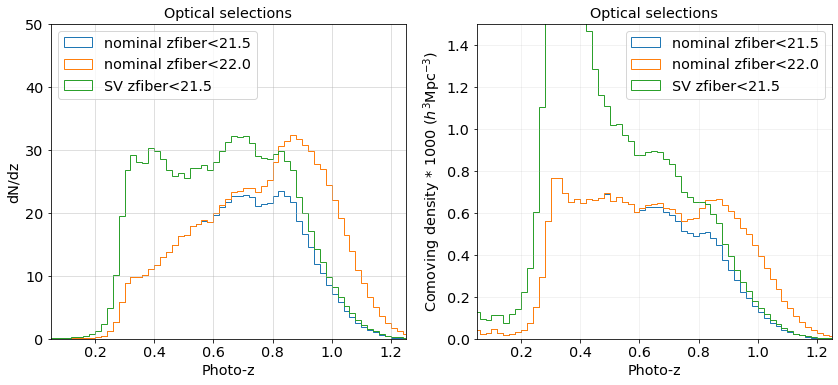

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5.8))
bins = np.arange(0.04, 1.44, 0.02)
axes[0].set_title('Optical selections')
axes[0].hist(z_phot_perturb[lrg_mask_opt_215], bins=bins, label='nominal zfiber<21.5', 
             weights=np.ones(int(np.sum(lrg_mask_opt_215)))/area_clean*downsample_factor, histtype='step')
axes[0].hist(z_phot_perturb[lrg_mask_opt_220], bins=bins, label='nominal zfiber<22.0', 
             weights=np.ones(int(np.sum(lrg_mask_opt_220)))/area_clean*downsample_factor, histtype='step')
axes[0].hist(z_phot_perturb[lrg_mask_sv_opt_215], bins=bins, label='SV zfiber<21.5', 
             weights=np.ones(int(np.sum(lrg_mask_sv_opt_215)))/area_clean*downsample_factor, histtype='step')
axes[0].set_xlabel('Photo-z')
axes[0].set_ylabel('dN/dz')
axes[0].set_xlim(0.05, 1.25)
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
# axes[0].set_ylim(0, 21.5)
axes[0].grid(alpha=0.5)
axes[0].set_ylim(top=50)
axes[0].legend(loc='upper left')
axes[1].set_title('Optical selections')
axes[1] = lrg_plot.plot_comoving_density(z_phot_perturb[lrg_mask_opt_215], area=area_clean/downsample_factor, zmin=0.04, zmax=1.44, dz=0.02, axis=[0.05, 1.25, 0, 1.5], show=False, label='nominal zfiber<21.5')
axes[1] = lrg_plot.plot_comoving_density(z_phot_perturb[lrg_mask_opt_220], area=area_clean/downsample_factor, zmin=0.04, zmax=1.44, dz=0.02, axis=[0.05, 1.25, 0, 1.5], show=False, label='nominal zfiber<22.0')
axes[1] = lrg_plot.plot_comoving_density(z_phot_perturb[lrg_mask_sv_opt_215], area=area_clean/downsample_factor, zmin=0.04, zmax=1.44, dz=0.02, axis=[0.05, 1.25, 0, 1.5], show=False, label='SV zfiber<21.5')

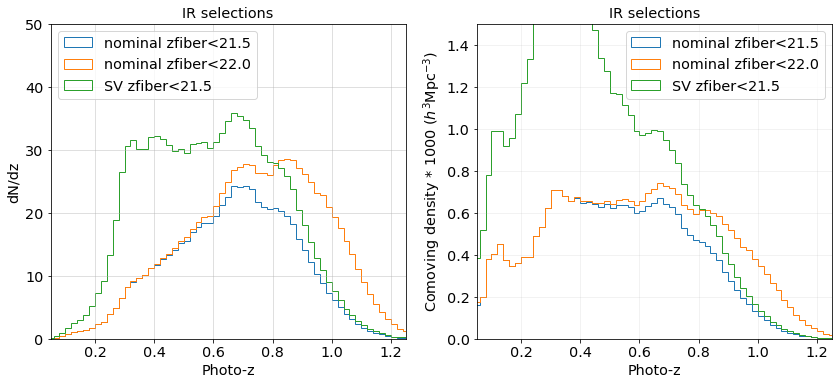

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5.8))
bins = np.arange(0.04, 1.44, 0.02)
axes[0].set_title('IR selections')
axes[0].hist(z_phot_perturb[lrg_mask_ir_215], bins=bins, label='nominal zfiber<21.5', 
             weights=np.ones(int(np.sum(lrg_mask_ir_215)))/area_clean*downsample_factor, histtype='step')
axes[0].hist(z_phot_perturb[lrg_mask_ir_220], bins=bins, label='nominal zfiber<22.0', 
             weights=np.ones(int(np.sum(lrg_mask_ir_220)))/area_clean*downsample_factor, histtype='step')
axes[0].hist(z_phot_perturb[lrg_mask_sv_ir_215], bins=bins, label='SV zfiber<21.5', 
             weights=np.ones(int(np.sum(lrg_mask_sv_ir_215)))/area_clean*downsample_factor, histtype='step')
axes[0].set_xlabel('Photo-z')
axes[0].set_ylabel('dN/dz')
axes[0].set_xlim(0.05, 1.25)
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
# axes[0].set_ylim(0, 21.5)
axes[0].grid(alpha=0.5)
axes[0].set_ylim(top=50)
axes[0].legend(loc='upper left')
axes[1].set_title('IR selections')
axes[1] = lrg_plot.plot_comoving_density(z_phot_perturb[lrg_mask_ir_215], area=area_clean/downsample_factor, zmin=0.04, zmax=1.44, dz=0.02, axis=[0.05, 1.25, 0, 1.5], show=False, label='nominal zfiber<21.5')
axes[1] = lrg_plot.plot_comoving_density(z_phot_perturb[lrg_mask_ir_220], area=area_clean/downsample_factor, zmin=0.04, zmax=1.44, dz=0.02, axis=[0.05, 1.25, 0, 1.5], show=False, label='nominal zfiber<22.0')
axes[1] = lrg_plot.plot_comoving_density(z_phot_perturb[lrg_mask_sv_ir_215], area=area_clean/downsample_factor, zmin=0.04, zmax=1.44, dz=0.02, axis=[0.05, 1.25, 0, 1.5], show=False, label='SV zfiber<21.5')

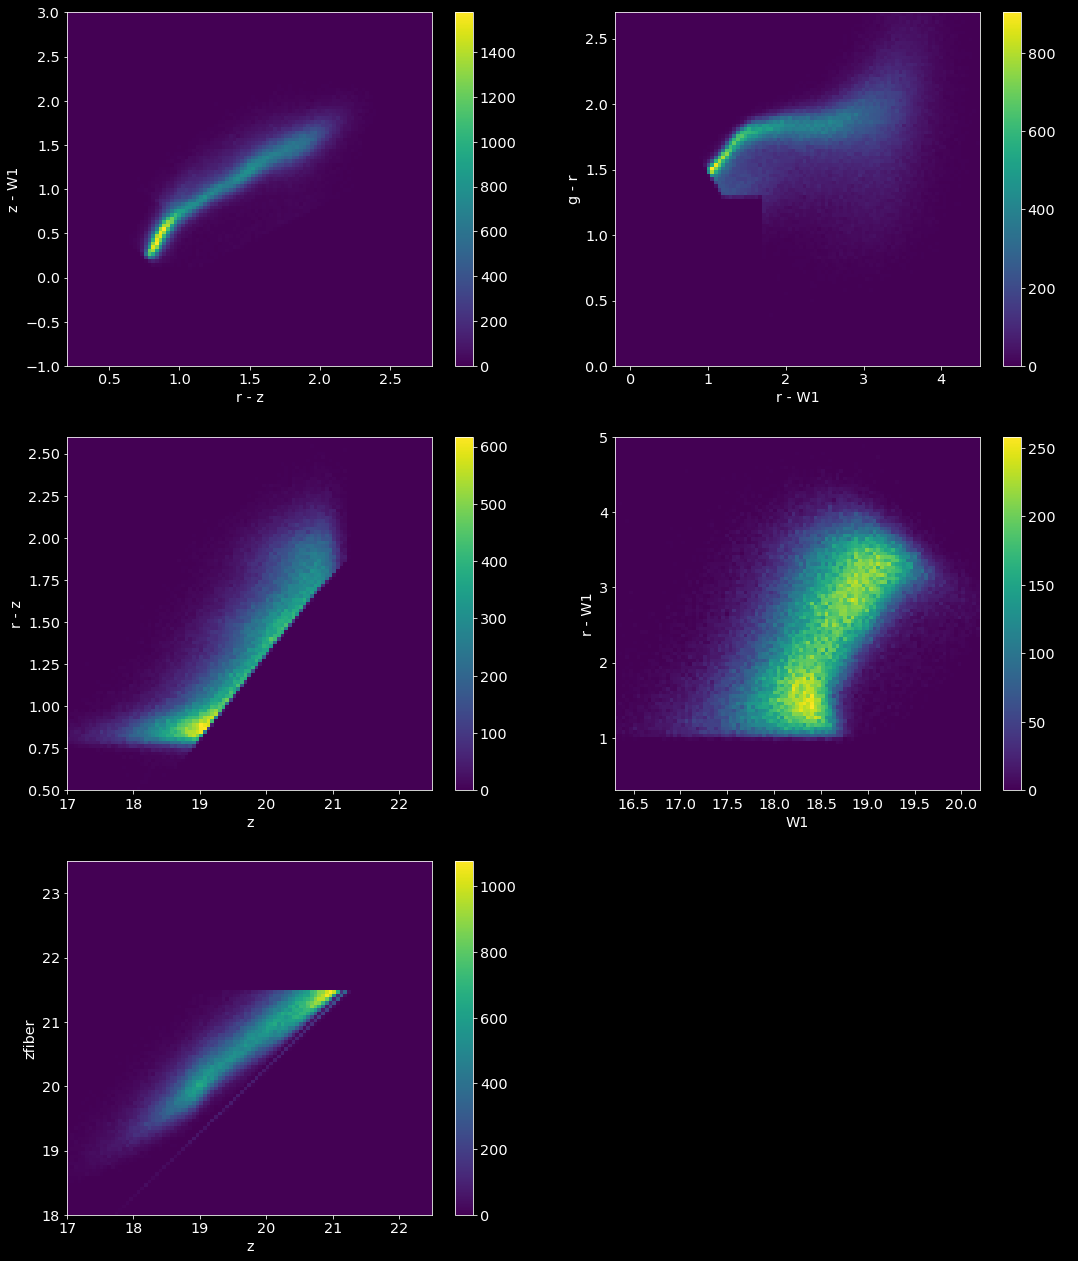

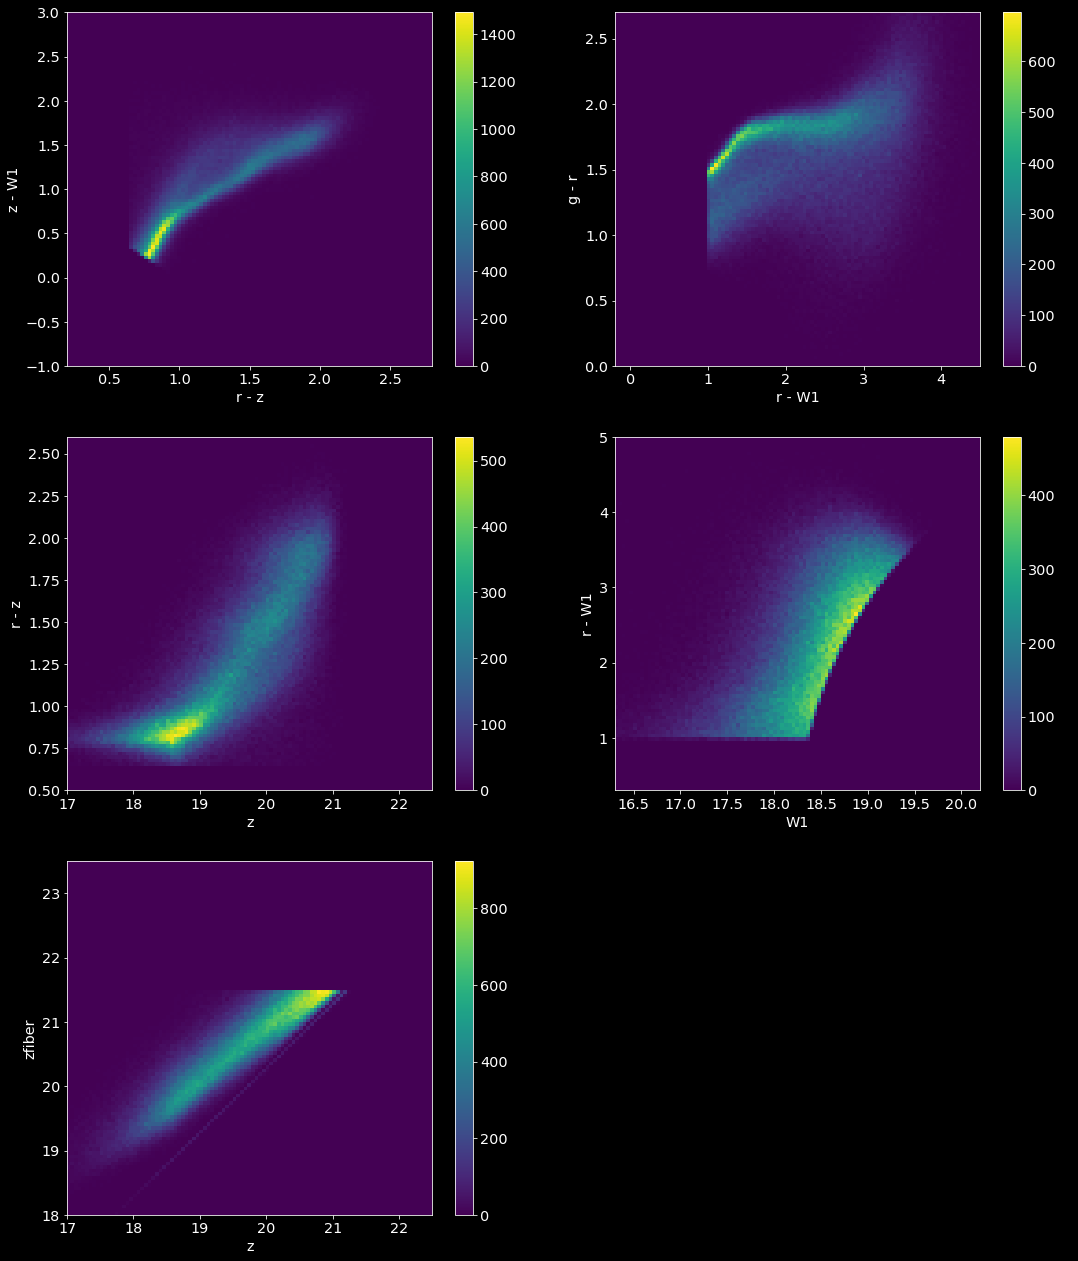

In [26]:
lrg_plot.density_plot_3x2_new(cat[lrg_mask_sv_opt_215], lognorm=False)
lrg_plot.density_plot_3x2_new(cat[lrg_mask_sv_ir_215], lognorm=False)

Conservative 1-pass/2-pass boundary:
    target density: 1384.6 (659.6+725.1) per sq deg
    exposure density: 2109.7 per sq deg
Conservative 1-pass/2-pass boundary:
    target density: 1505.4 (764.2+741.2) per sq deg
    exposure density: 2246.6 per sq deg


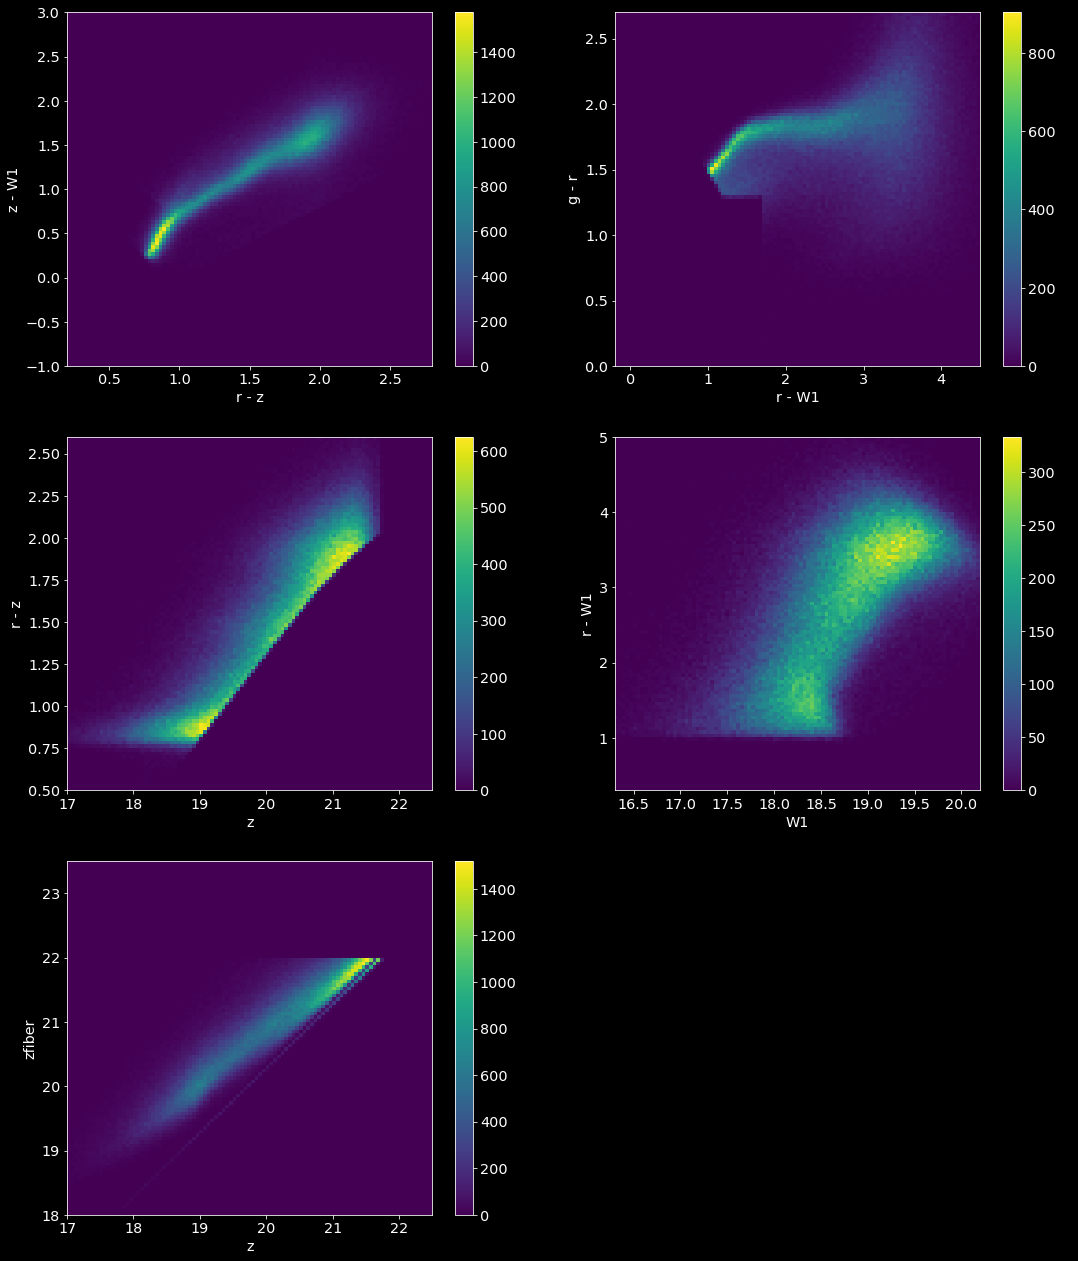

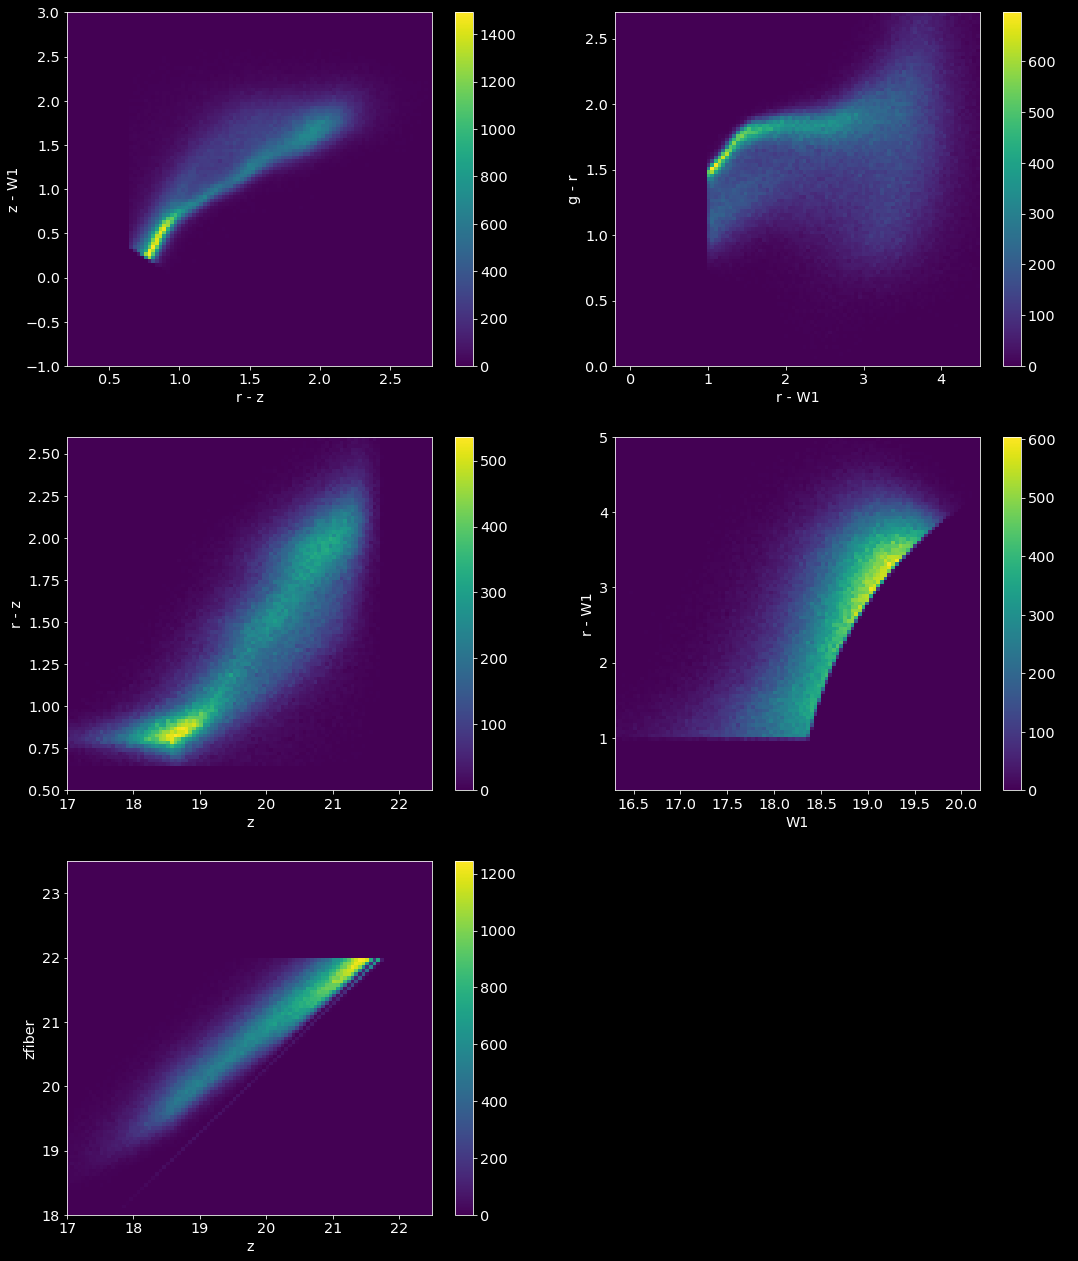

In [24]:
# Optical only
lrg_mask_sv_opt_220 = zmag - w1mag > 0.8*(rmag-zmag) - 0.8  # non-stellar cut
lrg_mask_sv_opt_220 &= ((zfibermag < 22.0))   # faint limit
mask_red = gmag - w1mag > 2.5                    # low-z cut
mask_red &= (gmag-rmag) > 1.3                    # red selection
mask_red |= (rmag-w1mag) > 1.7                   # ignore low-z cut for faint objects
lrg_mask_sv_opt_220 &= mask_red
# straight cut for low-z:
lrg_mask_lowz = zmag < 20.4
lrg_mask_lowz &= rmag - zmag > (zmag - 17.18 - 0.2) / 2
# curved sliding cut for high-z:
lrg_mask_highz = zmag > 20.4
lrg_mask_highz &= (((zmag - 23.52 - 0.2) / 1.3)**2 + (rmag - zmag + 2.2)**2 > 4.5**2)
lrg_mask_sv_opt_220 &= (lrg_mask_lowz | lrg_mask_highz)
print_summary(lrg_mask_sv_opt_220)

# IR only
lrg_mask_sv_ir_220 = zmag - w1mag > 0.8*(rmag-zmag) - 0.8  # non-stellar cut        
lrg_mask_sv_ir_220 &= ((zfibermag < 22.0)) # faint limit
lrg_mask_sv_ir_220 &= rmag - zmag > 0.65                    # broad color box
lrg_mask_sv_ir_220 &= (rmag - w1mag > 1.0) # Low-z cut
# curved sliding cut:
lrg_mask_sv_ir_220 &= (w1mag - 21.52 - 0.2)**2 + ((rmag - w1mag + 0.5) / 1.5)**2 >3.5**2
# lrg_mask_sv_ir_220 &= rmag - w1mag > (w1mag - 17.24 - 0.2) * 1.8  # sliding IR cut
print_summary(lrg_mask_sv_ir_220)

lrg_plot.density_plot_3x2_new(cat[lrg_mask_sv_opt_220], lognorm=False)
lrg_plot.density_plot_3x2_new(cat[lrg_mask_sv_ir_220], lognorm=False)